Importing the required libraries

In [24]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image

base_path='/workspaces/skin-segmentation-and-classification'

load train and test metadata 

In [25]:
train_metadata=pd.read_csv(f'{base_path}/train-metadata.csv')
test_metadata=pd.read_csv(f'{base_path}/test-metadata.csv')

#Accessing the first image
isic_id=train_metadata.iloc[0]['isic_id']
print(f'ISIC ID:{isic_id}')

#Scalar Data: Use data[()] to access scalar values.,
#Array Data: Use data[:] to access array data.
# Open the HDF5 file and inspect the structure,

with h5py.File(f'{base_path}/train-image.hdf5', 'r') as f:
    # Check if the ID exists ",
    if isic_id in f:
        data = f[isic_id]
        print(f"Data shape: {data.shape}")
        print(f"Data type: {type(data)}")
        if isinstance(data, h5py.Dataset):
             print(f"Dataset shape: {data.shape}")
            # Check if it's scalar or array
             if data.shape == ():  # Scalar
                  image = data[()]
                  print(f"Scalar data: {image}")
             else:
                  image = data[:]
                  print(f"Array data shape: {image.shape}")
        else:
             print("The data is not a dataset.")
    else:
         print(f"ISIC ID {isic_id} not found in the HDF5 file.")


/tmp/ipykernel_32467/39447186.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata=pd.read_csv(f'{base_path}/train-metadata.csv')


ISIC ID:ISIC_0015670
Data shape: ()
Data type: <class 'h5py._hl.dataset.Dataset'>
Dataset shape: ()
Scalar data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8b\x00\x8b\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2

Displaying the metadata

In [23]:
#training data
display(train_metadata.head(1))
#testing data
display(test_metadata.head(1))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.7,TBP tile: close-up,3D: XP,22.80433,20.00727,...,0.304827,1.281532,2.299935,0.479339,20,-155.0651,1511.222,113.9801,Memorial Sloan Kettering Cancer Center,CC-BY


handling imbalance in the dataset

In [28]:
#creating the copy of an original dataset
train_metadata_one=train_metadata.copy()

In [31]:
#creating the class to handle the imbalance in the dataset
class Config:
    verbose=1
    seed=42
    neg_sample=0.01
    pos_sample=4.0

In [26]:
# There is a data class imbalance in the dataset. To address this issue, 
# we are going to try downsampling and upsampling on the target class.

print('Class distribution ratio before sampling :')
print(train_metadata.target.value_counts(normalize=True)*100)

#we are performing the oversampling procedure on a minority class

positive_data = train_metadata_one.query("target==0").sample(frac=Config.neg_sample, random_state=Config.seed)
negative_data = train_metadata_one.query("target==1").sample(frac=Config.pos_sample, replace=True, random_state=Config.seed)
train_metadata_one = pd.concat([positive_data, negative_data], axis=0).sample(frac=1.0)
print('Class distribution ratio after sampling :')
print(train_metadata_one.target.value_counts(normalize=True)*100)

Class distribution ratio before sampling :
target
0    99.902009
1     0.097991
Name: proportion, dtype: float64
Class distribution ratio after sampling :
target
1    99.367889
0     0.632111
Name: proportion, dtype: float64


In [27]:
#Computing class weight to check data weights
from sklearn.utils.class_weight import compute_class_weight

# Assume df is your DataFrame and 'target' is the column with class labels

class_weights = compute_class_weight('balanced', classes=np.unique(train_metadata_one['target']), y=train_metadata_one['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(79.1), 1: np.float64(0.5031806615776081)}


Displaying the image from hdf5

In [34]:
# Open the HDF5 file and retrieve the image using the isic_id
with h5py.File(f'{base_path}/train-image.hdf5', 'r') as f:
    # Check if the ID exists
    if isic_id in f:
        data = f[isic_id]
        if data.shape != ():  # Ensure it's an array and not scalar
            image = data[:]
            # Display the image using matplotlib
            plt.imshow(image, cmap='gray')  # Adjust cmap depending on the image type (grayscale or RGB)
            plt.title(f'Image for ISIC ID: {isic_id}')
            plt.axis('off')  # Hide axis
            plt.show()
        else:
            print("The data is scalar, not an image.")
    else:
        print(f"ISIC ID {isic_id} not found in the HDF5 file.")


The data is scalar, not an image.


displaying the data from hdf5

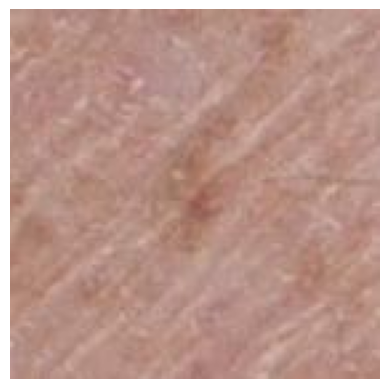

In [29]:
# Converting the scalar value to display an image
# Open the HDF5 file and retrieve the JPEG byte stream
with h5py.File(f'{base_path}/train-image.hdf5', 'r') as f:
    if isic_id in f:
        data = f[isic_id][()]
        if isinstance(data, bytes):  # Ensure data is in bytes
              # Decode the JPEG image from bytes
              image = Image.open(io.BytesIO(data))
            
            # Display the image
              plt.imshow(image)
              plt.axis('off')  # Hide axis/removes axis labels for cleaner display.
              plt.show()
        else:
             print("Data is not in bytes format.")
    else:
         print(f"ISIC ID {isic_id} not found in the HDF5 file.")

Feature Engineering

In [30]:
train_metadata_one.target.value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [32]:
#performing encoding methods on the categorical features
object_column=train_metadata.select_dtypes(include=['object']).columns

print('categorical columns are:', object_column)


categorical columns are: Index(['isic_id', 'patient_id', 'sex', 'anatom_site_general', 'image_type',
       'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple',
       'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1',
       'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index'],
      dtype='object')


Encoding and Normalization of dataset

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import HashingEncoder

def normalize_float_columns(df):
    float_columns = df.select_dtypes(include=['float64']).columns
    scaler = StandardScaler()
    df[float_columns] = scaler.fit_transform(df[float_columns])
    return df, scaler

def encode_and_normalize(df, cat_columns, max_unique=10, n_components=8):
    copy_data = df.copy()
    
    # Normalize float columns
    copy_data, _ = normalize_float_columns(copy_data)
    
    # Encode categorical columns
    for col in cat_columns:
        if col not in copy_data.columns:
            continue
        if copy_data[col].nunique() <= 2:
            le = LabelEncoder()
            copy_data[col] = le.fit_transform(copy_data[col])
        elif copy_data[col].nunique() <= max_unique:
            copy_data = pd.get_dummies(copy_data, columns=[col], prefix=col)
        else:
            he = HashingEncoder(cols=[col], n_components=n_components)
            encoded = he.fit_transform(copy_data[[col]])
            encoded.columns = [f"{col}_hash_{i}" for i in range(n_components)]
            copy_data = pd.concat([copy_data.drop(col, axis=1), encoded], axis=1)
    
    return copy_data
#main calling function
def process_in_chunks(df, cat_columns, chunk_size=10000):
    chunks = [df[i:i+chunk_size] for i in range(0, df.shape[0], chunk_size)]
    processed_chunks = []
    
    for chunk in chunks:
        processed_chunk = encode_and_normalize(chunk, cat_columns)
        processed_chunks.append(processed_chunk)
    
    return pd.concat(processed_chunks, axis=0)

# Get categorical columns that are present in both train and test metadata
train_object_columns = train_metadata_one.select_dtypes(include=['object']).columns
test_object_columns = test_metadata.select_dtypes(include=['object']).columns
common_object_columns = list(set(train_object_columns) & set(test_object_columns))

print("Common categorical columns:", common_object_columns)

# Process train metadata
copy_data_encoded = process_in_chunks(train_metadata_one, common_object_columns)

# Process test metadata
test_metadata_encoded = process_in_chunks(test_metadata, common_object_columns)

print("Processed train data:")
print(copy_data_encoded.head(3))
print("\nProcessed test data:")
print(test_metadata_encoded.head(3))

# Check for any remaining non-numeric columns
print("\nRemaining non-numeric columns in train data:")
print(copy_data_encoded.select_dtypes(exclude=[np.number]).columns)
print("\nRemaining non-numeric columns in test data:")
print(test_metadata_encoded.select_dtypes(exclude=[np.number]).columns)

Common categorical columns: ['copyright_license', 'tbp_lv_location', 'isic_id', 'image_type', 'anatom_site_general', 'patient_id', 'sex', 'tbp_tile_type', 'tbp_lv_location_simple', 'attribution']


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/extmath

Processed train data:
   target  age_approx  sex  clin_size_long_diam_mm  image_type  tbp_tile_type  \
0       0    0.149744    1               -0.508171           0              1   
1       0    0.149744    1               -1.612369           0              1   
2       0    0.149744    1               -0.303268           0              0   

   tbp_lv_A  tbp_lv_Aext  tbp_lv_B  tbp_lv_Bext  ...  \
0  0.063276     0.388931 -0.259604    -0.661996  ...   
1  2.954299     3.012807 -0.371684    -0.529013  ...   
2  0.651004     0.638612  1.834001     1.469838  ...   

   tbp_lv_location_simple_Torso Back  tbp_lv_location_simple_Torso Front  \
0                              False                               False   
1                              False                               False   
2                               True                               False   

   tbp_lv_location_simple_Unknown  attribution_ACEMID MIA  \
0                           False                   False   
1

In [36]:
#performing normalization on the numerical features
float_column=train_metadata_one.select_dtypes(include=['float'])
display(float_column.head(2))

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,...,9.307003,0.0,2.036195,2.637780,0.590476,-182.703552,613.493652,-42.427948,NaN,97.517282
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,...,3.354148,0.0,0.853227,3.912844,0.285714,-0.078308,1575.687000,57.174500,NaN,3.141455


Feature Selection

In [33]:
#it is best to handle nan values after encoding and normalization,
#because handling nan values before could introduce some incosistences.

from sklearn.impute import SimpleImputer

#before handling nan values summary
nan_summary = copy_data_encoded.isna().sum()
print("NaN values in each column:")
print(nan_summary[nan_summary > 0])

imputer = SimpleImputer(strategy = 'most_frequent')
numeric_columns = copy_data_encoded.select_dtypes(include=[np.number]).columns
copy_data_encoded[numeric_columns] = imputer.fit_transform(copy_data_encoded[numeric_columns])

# Remove columns with more than 50% NaN values
encoded_data = copy_data_encoded.dropna(axis=1, thresh=0.5 * len(copy_data_encoded))

# Remove rows with any NaN values
# encoded_data = copy_data_encoded.dropna(axis=0)

print("Remaining NaN values:", encoded_data.isna().sum().sum())


NaN values in each column:
lesion_id            3782
iddx_2               4001
iddx_3               4001
iddx_4               4591
iddx_5               5579
mel_mitotic_index    5372
dtype: int64
Remaining NaN values: 0


(5579, 64)


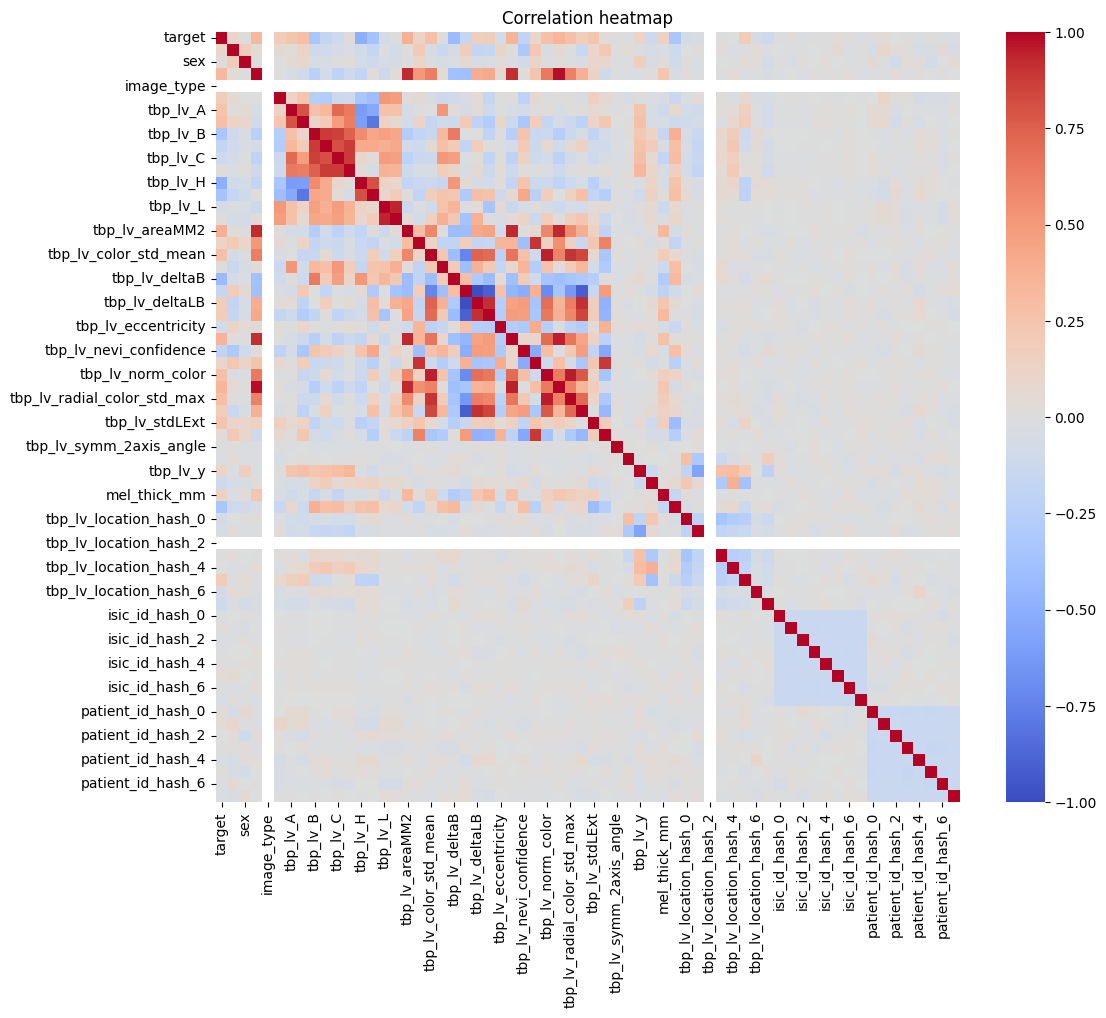

Highly corelated features pair
clin_size_long_diam_mm - tbp_lv_areaMM2: 0.92
clin_size_long_diam_mm - tbp_lv_minorAxisMM: 0.92
clin_size_long_diam_mm - tbp_lv_perimeterMM: 0.98
tbp_lv_A - tbp_lv_Aext: 0.80
tbp_lv_Aext - tbp_lv_Hext: -0.80
tbp_lv_B - tbp_lv_Bext: 0.88
tbp_lv_B - tbp_lv_C: 0.86
tbp_lv_Bext - tbp_lv_C: 0.81
tbp_lv_Bext - tbp_lv_Cext: 0.88
tbp_lv_C - tbp_lv_Cext: 0.88
tbp_lv_H - tbp_lv_Hext: 0.81
tbp_lv_L - tbp_lv_Lext: 0.94
tbp_lv_areaMM2 - tbp_lv_minorAxisMM: 0.93
tbp_lv_areaMM2 - tbp_lv_perimeterMM: 0.93
tbp_lv_area_perim_ratio - tbp_lv_norm_border: 0.90
tbp_lv_color_std_mean - tbp_lv_norm_color: 0.95
tbp_lv_color_std_mean - tbp_lv_radial_color_std_max: 0.91
tbp_lv_color_std_mean - tbp_lv_stdL: 0.84
tbp_lv_deltaL - tbp_lv_deltaLB: -0.99
tbp_lv_deltaL - tbp_lv_deltaLBnorm: -0.90
tbp_lv_deltaL - tbp_lv_stdL: -0.92
tbp_lv_deltaLB - tbp_lv_deltaLBnorm: 0.91
tbp_lv_deltaLB - tbp_lv_stdL: 0.91
tbp_lv_deltaLBnorm - tbp_lv_stdL: 0.85
tbp_lv_minorAxisMM - tbp_lv_perimeterMM: 0.9

In [37]:
#this section perform feature selection 
import matplotlib.pyplot as plt
import seaborn as sns

#encoded_data is the dataset with balanced class weight, encoded, normalized and handled nan values. 

#Selecting numeric column considering all the dataset is in numeric
numeric_data=encoded_data.select_dtypes(include=[np.number])

#Computing the correlation matrix corr()
correlation_matrix = numeric_data.corr()

print(numeric_data.shape)
#Visualize the matrix
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Correlation heatmap')
plt.show()

#displaying all the highly correlated feature pairs
print('Highly corelated features pair')
high_corr_threshold = 0.8
high_corr = np.where(np.abs(correlation_matrix) > high_corr_threshold)
high_corr_list = [(correlation_matrix.index[x],
                   correlation_matrix.columns[y],correlation_matrix.iloc[x,y])
                   for x, y in zip(*high_corr) if x!=y and x < y]

for feat1, feat2, corr in high_corr_list:
    print(f"{feat1} - {feat2}: {corr:.2f}")

# 5. Correlation with target variable (if applicable)
# Assuming your target variable is named 'target'. Replace with your actual target column name.
target_column = 'target'  # Replace with your actual target column name

if target_column in numeric_data.columns:
    target_correlations = numeric_data.corr()[target_column].sort_values(ascending=False)
    print("\nFeature correlations with target variable:")
    print(target_correlations)
else:
    print(f"\nTarget variable '{target_column}' not found in the dataset.")

# 6. Optional: Remove one of the highly correlated features greater than the threshold 0.8
def remove_correlated_features(dataset, threshold):
    corr_matrix = dataset.corr().abs()
    print(corr_matrix)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return dataset.drop(to_drop, axis=1)

#removing highly correlated features
reduced_data = remove_correlated_features(numeric_data, 0.8)
print(f"\nShape after removing highly correlated features: {reduced_data.shape}")



train_test_split and model building

In [39]:
from sklearn.model_selection import train_test_split

#loading train_images now from hdf5 file

def load_hdf5(file_path):
    with h5py.File(file_path,'r') as hf:
        return {key: np.array(hf[key]) for key in hf.keys()}
    
train_images=load_hdf5('/workspaces/skin-segmentation-and-classification/train-image.hdf5')
test_images=load_hdf5('/workspaces/skin-segmentation-and-classification/test-image.hdf5')


#combining image and metadata reduced_data
def combine_data(images, metadata):
    combined_data = []
    for isic_id, row in metadata.iterrows():
        if isic_id in images:
            combined_data.append((images[isic_id], row.values))
    return combined_data

train_data = combine_data(train_images, reduced_data)
#test_data = combine_data(test_images, test_metadata_processed)

# Split training data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


/tmp/ipykernel_32467/2638966486.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return {key: np.array(hf[key]) for key in hf.keys()}


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.